<IPython.core.display.Javascript object>


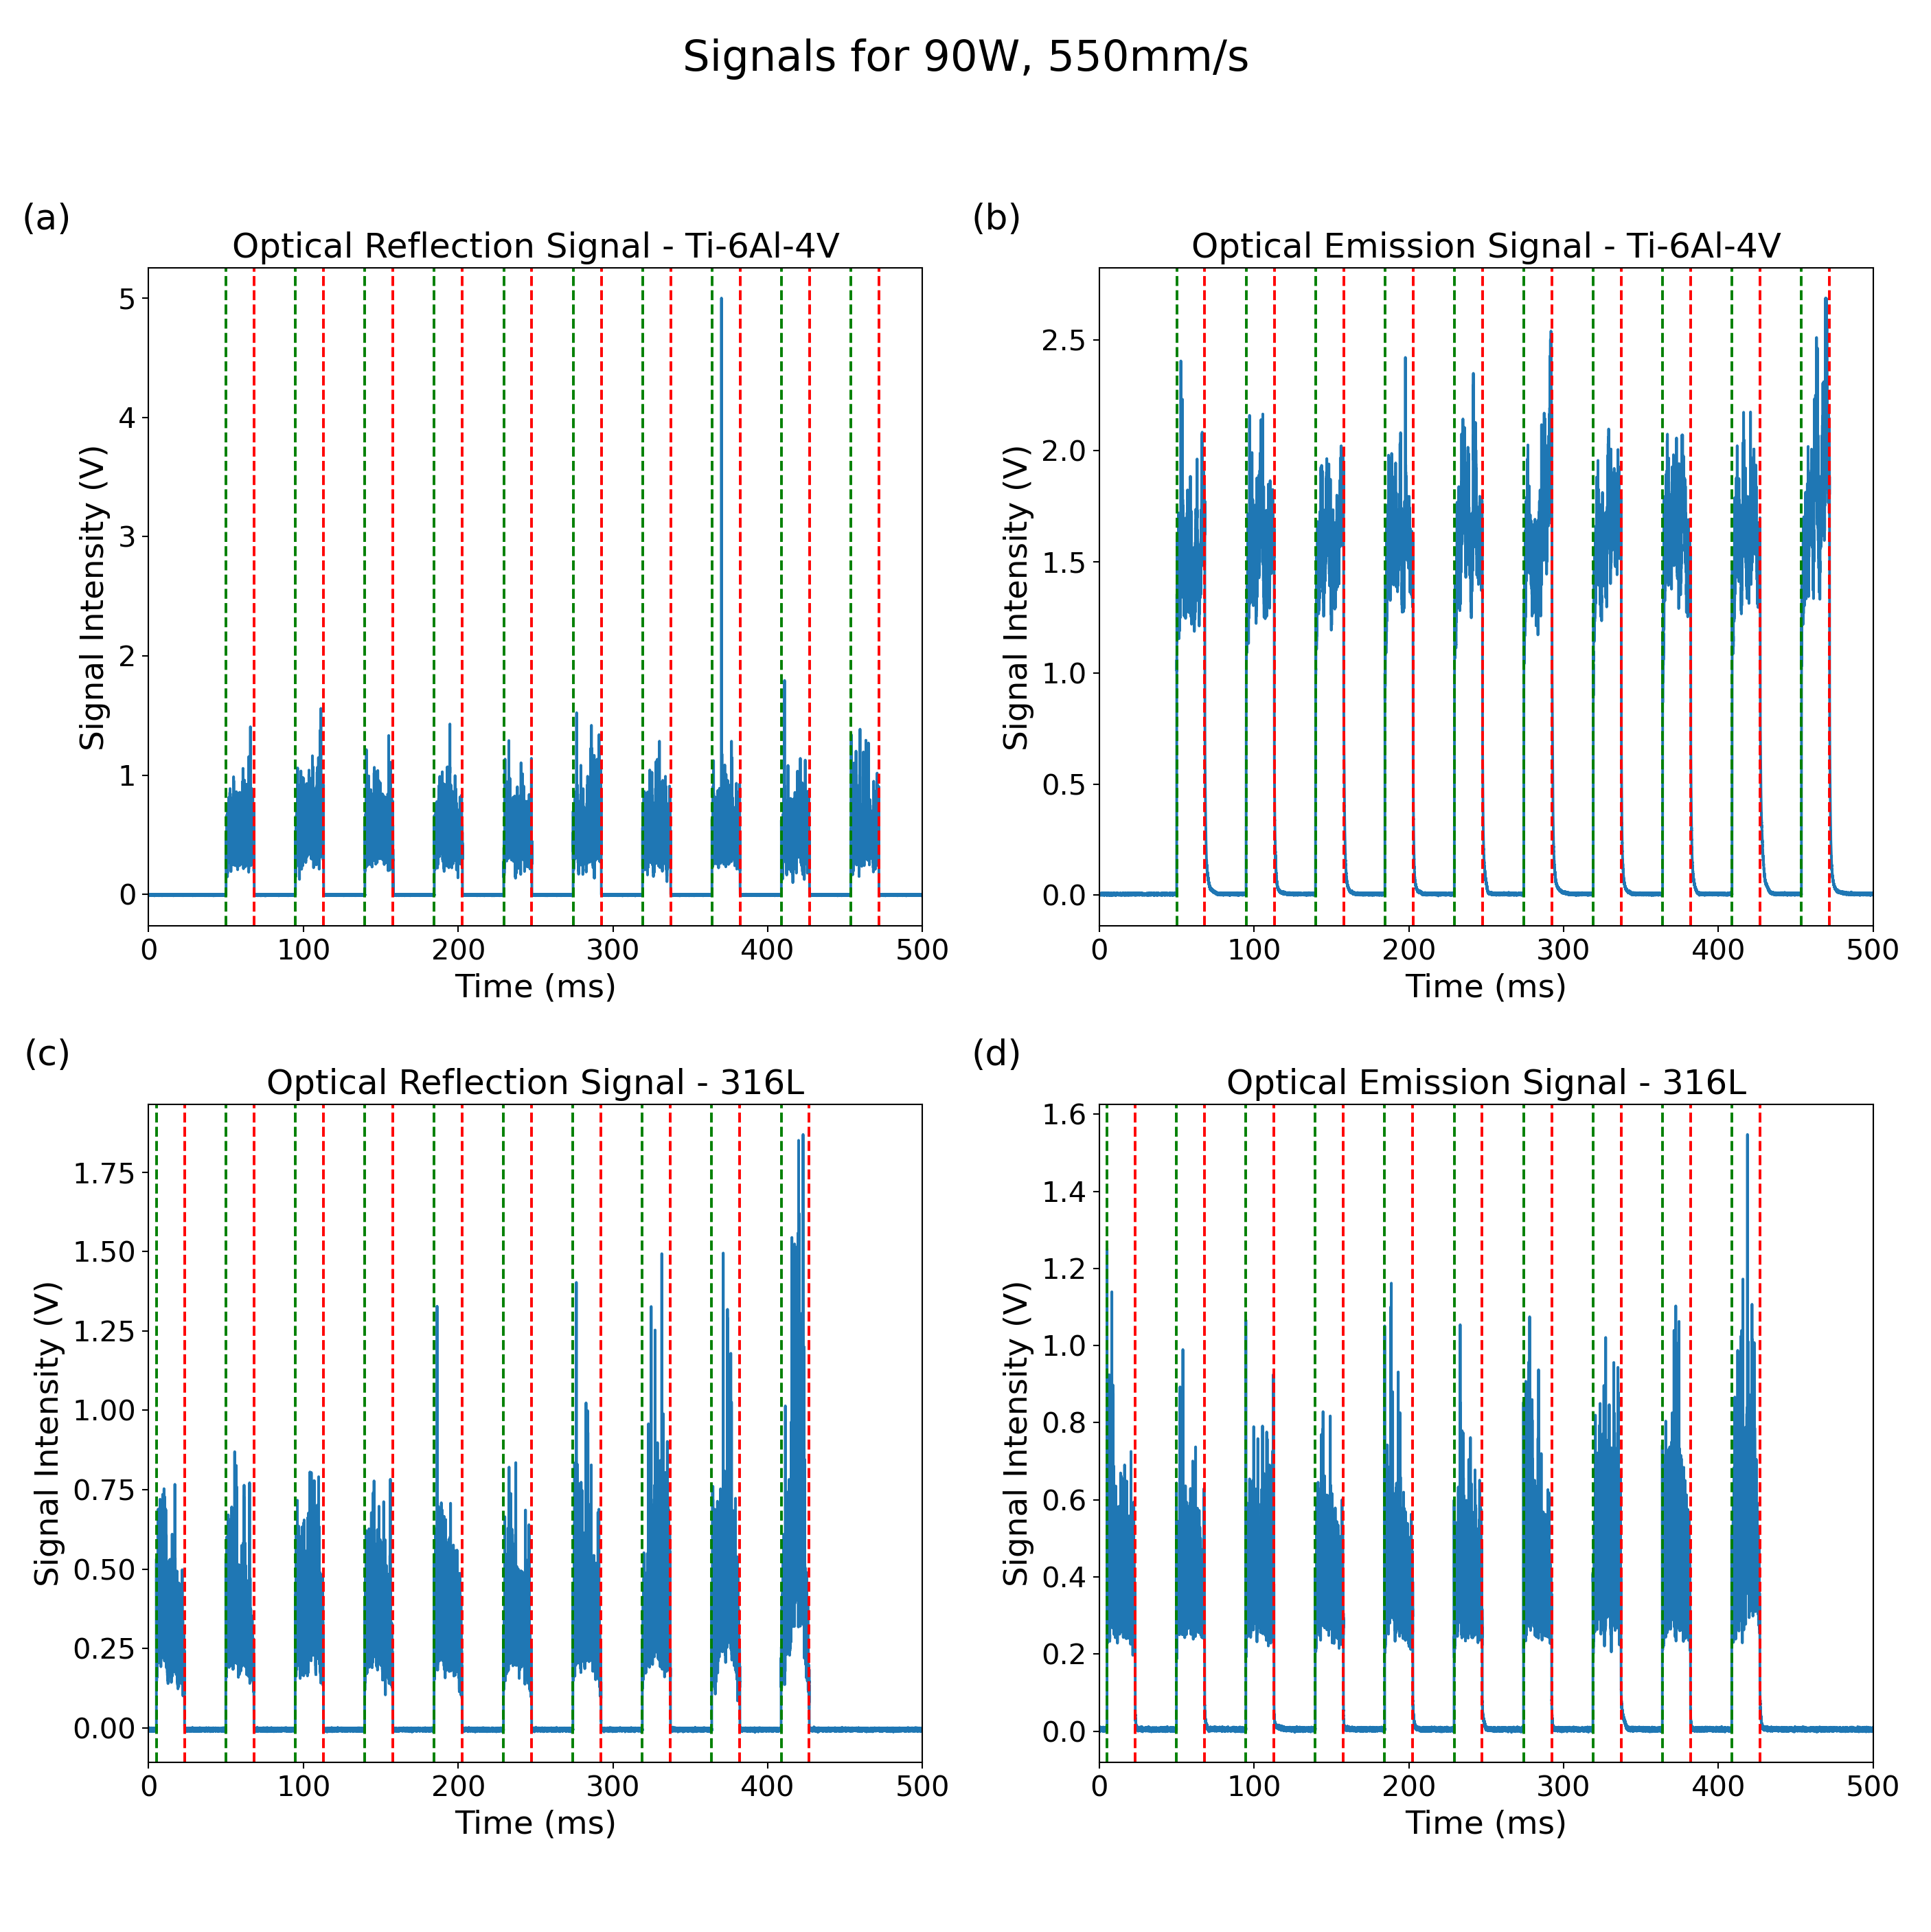

Plot saved as Figures/signals_90W_550mms.pdf


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import skimage.morphology

%matplotlib notebook

# Set the global font size
plt.rcParams.update({'font.size': 16})

def computeBoundaries(signal, th):
    locs = np.where(signal > th)[0]
    indexes = np.zeros((signal.shape[0], 1))
    indexes[locs] = 1

    selem = np.ones((70, 1))
    closed = skimage.morphology.closing(indexes, selem)
    opened = skimage.morphology.opening(closed, selem)

    locsNew = np.where(opened == 1)[0]
    derNew = np.diff(locsNew)
    ind = np.where(derNew > 1)[0]

    ending = np.append(locsNew[ind], locsNew[-1])
    starting = np.append(locsNew[0], locsNew[ind + 1])

    return starting, ending

def plot_signals_with_boundaries(materials, power, speed, threshold=0.1):
    # Path to the Excel file with parameters
    excel_path = './experiment_parameters.xlsx'
    xl = pd.ExcelFile(excel_path)

    # Load parameters from Excel into a dictionary
    params_dict = {}
    for sheet_name in xl.sheet_names:
        df = xl.parse(sheet_name)
        params_dict[sheet_name] = df[['Speed (mm/s)', 'Power (W)', 'Power perc (%)']].to_dict('records')

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle(f'Signals for {power}W, {speed}mm/s', fontsize=24)
    
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']

    for idx, material in enumerate(materials):
        base_path = f'./Data/Neuchatel_{material}/'
        
        plotted = False
        for cube_number in range(1, 4):  
            if plotted:
                break
            
            cube_name = f'Cube{cube_number}'
            cube_path = os.path.join(base_path, cube_name)

            # Find the condition that matches the specified power and speed
            condition = next((i for i, param_set in enumerate(params_dict[cube_name]) 
                              if param_set['Power (W)'] == power and param_set['Speed (mm/s)'] == speed), None)

            if condition is not None:
                # Load channel data
                data_channel_0 = pd.read_csv(os.path.join(cube_path, 'channel_0', f'File_{condition}.csv')).to_numpy().flatten()
                data_channel_1 = pd.read_csv(os.path.join(cube_path, 'channel_1', f'File_{condition}.csv')).to_numpy().flatten()

                # Calculate time array for plotting
                sampling_rate = 200000  # 200,000 Hz
                time_step = 1 / sampling_rate * 1000  # Time step in ms
                time_array = np.arange(data_channel_0.size) * time_step

                # Compute boundaries
                starting, ending = computeBoundaries(data_channel_0, threshold)
                
                if material == 'Ti64':
                    material = 'Ti-6Al-4V'

                # Plot OR (channel_0)
                axes[idx, 0].plot(time_array, data_channel_0, label=f'{material}')
                axes[idx, 0].set_title(f'Optical Reflection Signal - {material}')
                axes[idx, 0].set_xlabel('Time (ms)', fontsize=18)
                axes[idx, 0].set_ylabel('Signal Intensity (V)', fontsize=18)
                axes[idx, 0].text(-0.1, 1.1, subplot_labels[idx*2], transform=axes[idx, 0].transAxes, 
                                fontsize=20, va='top', ha='right')
                
                # Plot OE (channel_1)
                axes[idx, 1].plot(time_array, data_channel_1, label=f'{material}')
                axes[idx, 1].set_title(f'Optical Emission Signal - {material}')
                axes[idx, 1].set_xlabel('Time (ms)', fontsize=18)
                axes[idx, 1].set_ylabel('Signal Intensity (V)', fontsize=18)
                axes[idx, 1].text(-0.1, 1.1, subplot_labels[idx*2+1], transform=axes[idx, 1].transAxes, 
                                fontsize=20, va='top', ha='right')

                # Add markers for the start and end of each segment
                for start, end in zip(starting, ending):
                    axes[idx, 0].axvline(x=time_array[start], color='green', linestyle='--')
                    axes[idx, 0].axvline(x=time_array[end], color='red', linestyle='--')
                    axes[idx, 1].axvline(x=time_array[start], color='green', linestyle='--')
                    axes[idx, 1].axvline(x=time_array[end], color='red', linestyle='--')

                plotted = True

        if not plotted:
            axes[idx, 0].text(0.5, 0.5, f'No data for {material}\nat {power}W, {speed}mm/s', 
                              ha='center', va='center', transform=axes[idx, 0].transAxes)
            axes[idx, 1].text(0.5, 0.5, f'No data for {material}\nat {power}W, {speed}mm/s', 
                              ha='center', va='center', transform=axes[idx, 1].transAxes)

    for ax in axes.flatten():
        #ax.legend()
        ax.set_xlim(0, 500)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Create Figures folder if it doesn't exist
    if not os.path.exists('Figures'):
        os.makedirs('Figures')
    
    # Save the plot as PDF
    filename = f'Figures/signals_{power}W_{speed}mms.pdf'
    plt.savefig(filename, format='pdf', dpi=150, bbox_inches='tight')
    print(f"Plot saved as {filename}")
    plt.show()

materials = ['Ti64', '316L']
power = 90  # Specify the desired power in Watts
speed = 550  # Specify the desired speed in mm/s
plot_signals_with_boundaries(materials, power, speed)
